In [1]:
import os
import sys
import PIL
import copy
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

from pylensmodels.mass.spemd import SPEMD_glee
from pylensmodels.light.gaussian import Gaussian, GaussianElliptical
from pylensmodels.utils import coordinates
from MuSLIT.lensing import planes
from MuSLIT.utils.plot import nice_colorbar

lin = lambda x: x
log = lambda x: np.log10(x)

# 1. Generate a mass model
Simple SPEMD profile, using GLEE parameter conventions

In [2]:
num_pix = 100
x_grid, y_grid = coordinates.square_grid(num_pix)
print(x_grid, y_grid)

#extra_num_pix = 3000
#x_grid_large, y_grid_large = coordinates.square_grid(num_pix + extra_num_pix)

source_to_image_ratio = 1
num_pix_src = num_pix * source_to_image_ratio

[ 0.  1.  2. ... 97. 98. 99.] [ 0.  0.  0. ... 99. 99. 99.]


In [3]:
kwargs_spemd = {
    'x0': 50.5,  # pixels (origin : lower left pixel)
    'y0': 50.5,  # pixels (origin : lower left pixel)
    'gamma': 0.3,
    'theta_E': 25.,  # pixels
    'q': 0.8,
    'phi': 0.3,
    'r_core': 0.01,  # pixels
}

# WARNING : no Dds/Ds (physical to scaled conversion) scaling
mass_model = SPEMD_glee(kwargs_spemd, Dds_Ds=None)
kappa = mass_model.convergence(x_grid, y_grid)
alpha1, alpha2 = mass_model.deflection(x_grid, y_grid)

#kwargs_spemd_large = copy.deepcopy(kwargs_spemd)
#kwargs_spemd_large['x0'] = kwargs_spemd['x0'] + extra_num_pix/2
#kwargs_spemd_large['y0'] = kwargs_spemd['y0'] + extra_num_pix/2
#kappa_large = mass_model_large.convergence(x_grid_large, y_grid_large)
#mass_model_large = SPEMD_glee(kwargs_spemd_large, Dds_Ds=None)

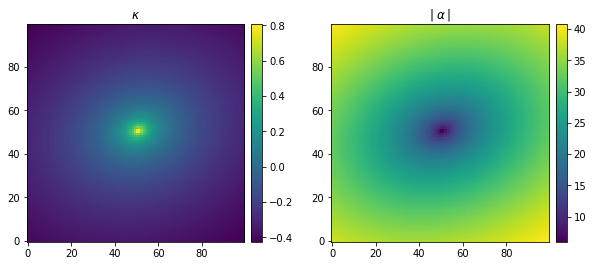

In [4]:
ax = plt.subplot2grid((1, 2), (0, 0), fig=plt.figure(figsize=(10, 4)))
im = ax.imshow(np.log10(kappa), origin='lower')
ax.set_title("$\kappa$")
nice_colorbar(im)

ax = plt.subplot2grid((1, 2), (0, 1))
im = ax.imshow(np.sqrt(alpha1**2+alpha2**2), origin='lower')
ax.set_title(r"$|\ \alpha\,|$")
nice_colorbar(im)
plt.show()

Deflection angles have been provided
<class 'list'> 10000


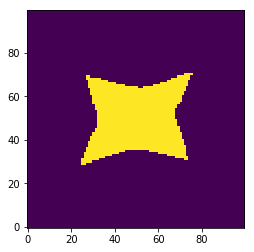

In [5]:
lensing_operator = planes.build_lensing_operator(None, num_pix, source_to_image_ratio, 
                                                 alpha_x_in=alpha1, alpha_y_in=alpha2)
print(type(lensing_operator), len(lensing_operator))
#lensing_operator_kappa = planes.build_lensing_operator(kappa_large, num_pix, source_to_image_ratio)

image_ones = np.ones((num_pix, num_pix))
source_ones = planes.image_to_source(image_ones, lensing_operator, num_pix_src)
#source_ones_kappa = planes.image_to_source(image_ones, lensing_operator_kappa, num_pix_src)

plt.imshow(source_ones, origin='lower')
plt.show()

# 2. Simulate a single-band image

In [6]:
kwargs_gaussian_ell = {'x0': 51, 'y0': 52, 'sigma': 2, 'phi': 0.3, 'q': 0.6, 'amp': 1}
gaussian_source = GaussianElliptical(kwargs_gaussian_ell).function(x_grid, y_grid)

kwargs_gaussian = {'x0': 50, 'y0': 50, 'sigma_x': 8, 'sigma_y': 8, 'amp': 7}
gaussian_lens = Gaussian(kwargs_gaussian).function(x_grid, y_grid)

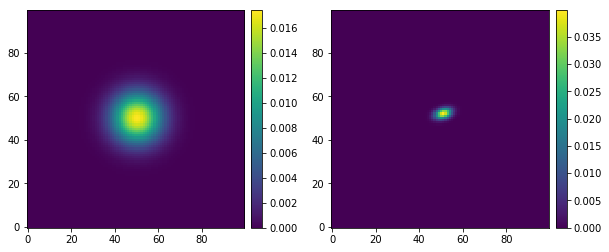

In [7]:
ax = plt.subplot2grid((1, 2), (0, 0), fig=plt.figure(figsize=(10, 4)))
im= ax.imshow(gaussian_lens, origin='lower')
nice_colorbar(im)

ax = plt.subplot2grid((1, 2), (0, 1))
im= ax.imshow(gaussian_source, origin='lower')
nice_colorbar(im)

plt.show()

In [8]:
#data_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Data/various_images'
#galaxy_source = pyfits.open(os.path.join(data_dir, 'M81_HST_prepared_n100.fits'))[0].data
#print(galaxy_source.shape)
#
#plt.imshow(galaxy_source, origin='lower')
#plt.colorbar()
#plt.show()

In [9]:
# normalization
galaxy_source = gaussian_source/gaussian_source.max()
galaxy_lens   = gaussian_lens/gaussian_lens.max()

In [10]:
galaxy_lensed = planes.source_to_image(galaxy_source, lensing_operator, num_pix)
print(galaxy_lensed.max())

galaxy_unlensed = planes.image_to_source(galaxy_lensed, lensing_operator, num_pix_src)
print(galaxy_unlensed.max())

1.0
0.9999999999999999


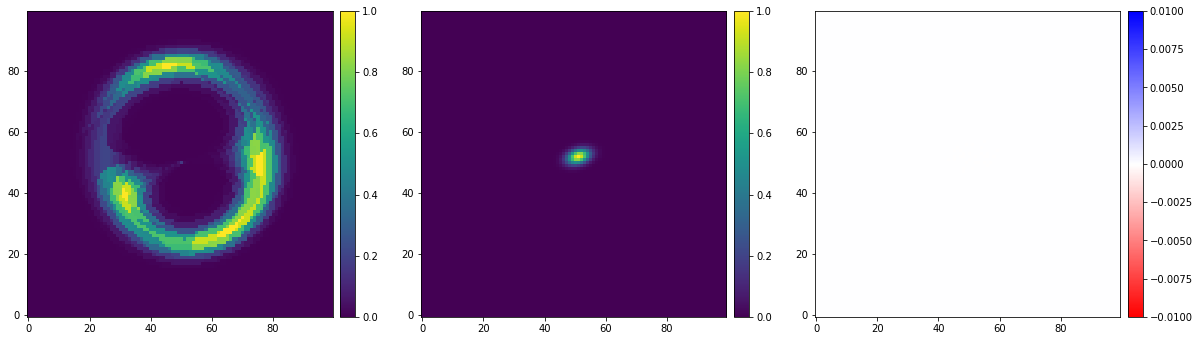

In [11]:
ax = plt.subplot2grid((1, 3), (0, 0), fig=plt.figure(figsize=(20, 6)))
im = ax.imshow(galaxy_lensed, origin='lower')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 1))
im = ax.imshow(galaxy_unlensed, origin='lower')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 2))
im = ax.imshow(galaxy_source-galaxy_unlensed, origin='lower', cmap='bwr_r', vmin=-0.01, vmax=0.01)
nice_colorbar(im)
plt.show()

In [12]:
sim_lens_base = galaxy_lensed + galaxy_lens

# 3. Generate a multi(3)-band image

In [13]:
def bands2image(band_list):
    return np.stack(band_list, axis=2)

def plot_rgb_bands(color_image_np):
    band_r = color_image_np[:,:,0]
    band_g = color_image_np[:,:,1]
    band_b = color_image_np[:,:,2]
    vmax = max((band_r.max(), band_g.max(), band_b.max()))
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    ax = axes[0]
    im = ax.imshow(band_r, origin='lower', cmap='Reds_r', vmax=vmax)
    #fig.colorbar(im, ax=ax)
    ax = axes[1]
    ax.imshow(band_g, origin='lower', cmap='Greens_r', vmax=vmax)
    ax = axes[2]
    ax.imshow(band_b, origin='lower', cmap='Blues_r', vmax=vmax)
    ax = axes[3]
    ax.imshow(lin(color_image_np), origin='lower')
    plt.show()

## Define spectral energy distributions

In [14]:
lens_SEDs   = (1.0, 0.7, 0.4)   # not normalized
source_SEDs = (0.6, 0.7, 0.8)   # not normalized

lens_multiband = [galaxy_lens * sed for sed in lens_SEDs]
lens_multiband = bands2image(lens_multiband)

lensed_multiband = [planes.source_to_image(galaxy_source*sed, lensing_operator, num_pix) for sed in source_SEDs]
lensed_multiband = bands2image(lensed_multiband)

In [15]:
sim_lens_multiband_no_noise = lens_multiband + lensed_multiband

## Add noise
_Only gaussian for simplicity_

In [16]:
noise1 = np.random.randn(num_pix, num_pix) * 0.05  # arbitrary units for now
noise2 = np.random.randn(num_pix, num_pix) * 0.05
noise3 = np.random.randn(num_pix, num_pix) * 0.05
noise_multiband = bands2image([noise1, noise2, noise3])

sim_lens_multiband = sim_lens_multiband_no_noise + noise_multiband

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


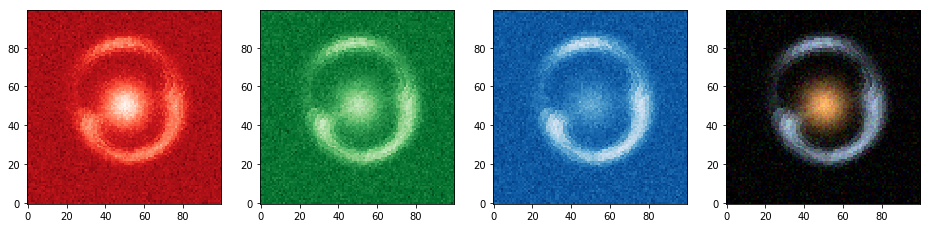

In [17]:
plot_rgb_bands(sim_lens_multiband)